## Database Query

In [123]:
"""從sqlite撈取資料庫"""
conn = sqlite3.connect('mydatabase1.db')
cursor = conn.cursor()

df = pd.read_sql("SELECT board,title FROM PTT",conn)
conn.close()
print(df)

            board                                   title
0             NBA              \n[花邊] 到1/21為止所有球員TPA排行圖\n
1             NBA                         \n[公告] 板規10.1\n
2             NBA  \n[情報] SEASON Schedule January 22–23\n
3             NBA                         \n[公告] 板主徵選開始\n
4             NBA  \n[情報] NBA Standings (Jan. 22, 2023)\n
...           ...                                     ...
2923  Lifeismoney          \n[情報] 韓味不二 湯品鍋物7入禮盒 $968 免運\n
2924  Lifeismoney           \nRe: [新聞] 12月份壽星優惠 20大餐廳優惠\n
2925  Lifeismoney                 \n[情報] 統一精工2023上半年度活動\n
2926  Lifeismoney                       \n[情報] 熊好券 終極加碼\n
2927  Lifeismoney   \n[情報] EPIC《氣球塔防 6》免費 至 12/17 00:00\n

[2928 rows x 2 columns]


## Data Overview

In [6]:
df.head()

,board,title
0,NBA,\n[花邊] 到1/21為止所有球員TPA排行圖\n
1,NBA,\n[公告] 板規10.1\n
2,NBA,\n[情報] SEASON Schedule January 22–23\n
3,NBA,\n[公告] 板主徵選開始\n
4,NBA,"\n[情報] NBA Standings (Jan. 22, 2023)\n"


In [10]:
df.describe()

,board,title
count,2928,2928
unique,5,2531
top,Lifeismoney,\nRe: [討論] 為何男生不會追求儀式感？\n
freq,592,32


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   board   2928 non-null   object
 1   title   2928 non-null   object
dtypes: object(2)
memory usage: 45.9+ KB


In [4]:
# Number of post on each board
board_count={}
for i in df['board'].unique():
    board_count[i] = list(df['board']).count(i)
print(board_count)

{'NBA': 579, 'Stock': 579, 'Boy-Girl': 589, 'Baseball': 589, 'Lifeismoney': 592}


## Feature Engineering

1. '\n' in title
3. drop 公告
2. jieba
4. 版名
5. Train Test Split
6. Vectorization

In [3]:
# '\n'
for i in range(len(df)):
    df['title'][i] = df['title'][i].replace('\n','')

In [ ]:
# 公告
for i in range(len(df)):
    if ("[公告]" in df['title'][i]):
        print(df['title'][i])
        df = df.drop(i)
df = df.reset_index(drop=True)

In [16]:
#jieba
import jieba
stopfile = "stopword.txt"  # stopwords
stopwords= [line.strip() for line in open(stopfile,encoding="utf-8").readlines()]
def cut_text(text):
    cutlist=[]

    cut = jieba.cut(text)
    for i in list(cut):
        if i not in stopwords:
            cutlist.append(i)
    return " ".join(cutlist)

df['text'] = df['title'].apply(cut_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Y.C\AppData\Local\Temp\jieba.cache
Loading model cost 3.120 seconds.
Prefix dict has been built successfully.


In [17]:
#版名mapping
df['board'] = df['board'].map({'NBA':0,'Stock':1,'Boy-Girl':2,'Baseball':3,'Lifeismoney':4}).astype(int)

In [22]:
#Train_Test_raito (TRAIN(train+valid)/TEST)
train_test_raito = 0.8
df_train = df.sample(frac=train_test_raito,random_state=3)
df_test = df.drop(df_train.index)


In [23]:
#Vectorization
#將文章標題的所有出現過的詞作成一個大字典，並透過這個字典把所有詞彙都轉成向量。
# 準備排序的文字list(keywordindex)
total_words = ' '.join(df['text'])
vectorterms = list(set(total_words))

# 轉化每個文章標題的詞變成向量
def vectorize(words):
    self_main_list = [0] * len(vectorterms)
    for term in words:
        if term in vectorterms:  # 因為測試資料集當中的詞不一定有出現在訓練資料集中
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
    return np.array(self_main_list)

# Tokenized後的文章標題做向量化
X_vector = np.concatenate(df_train['text'].apply(vectorize).values).reshape(-1, len(vectorterms))

In [101]:
df.head()

,board,title,text
0,0,[花邊] 到1/21為止所有球員TPA排行圖,花邊 1 21 為止 所有 球員 TPA 排行 圖
1,0,[情報] SEASON Schedule January 22–23,情報 SEASON Schedule January 22 – 23
2,0,"[情報] NBA Standings (Jan. 22, 2023)",情報 NBA Standings Jan 22 2023
3,0,[外絮] 西門寄發律師函要求Maya Jama歸還訂婚戒指,外絮 西門 寄 發律 師函 要求 Maya Jama 歸 還訂 婚 戒指
4,0,Re: [討論] 所以為啥LBJ黑這麼多啊？,Re 討論 所以 LBJ 黑 這麼 多 啊


## Data Visualization

<AxesSubplot:xlabel='board'>

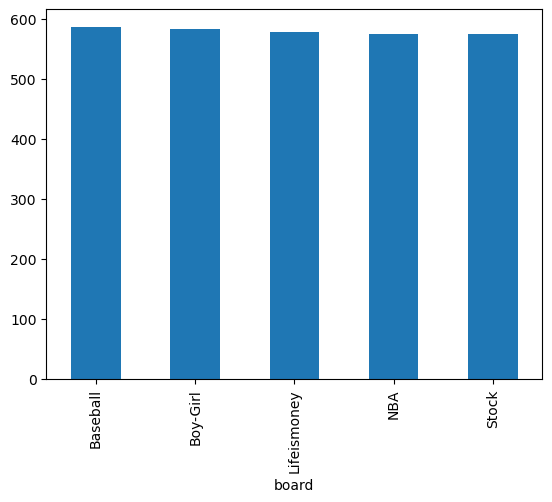

In [9]:
groups = df.groupby('board')
groups.size().plot(kind='bar')

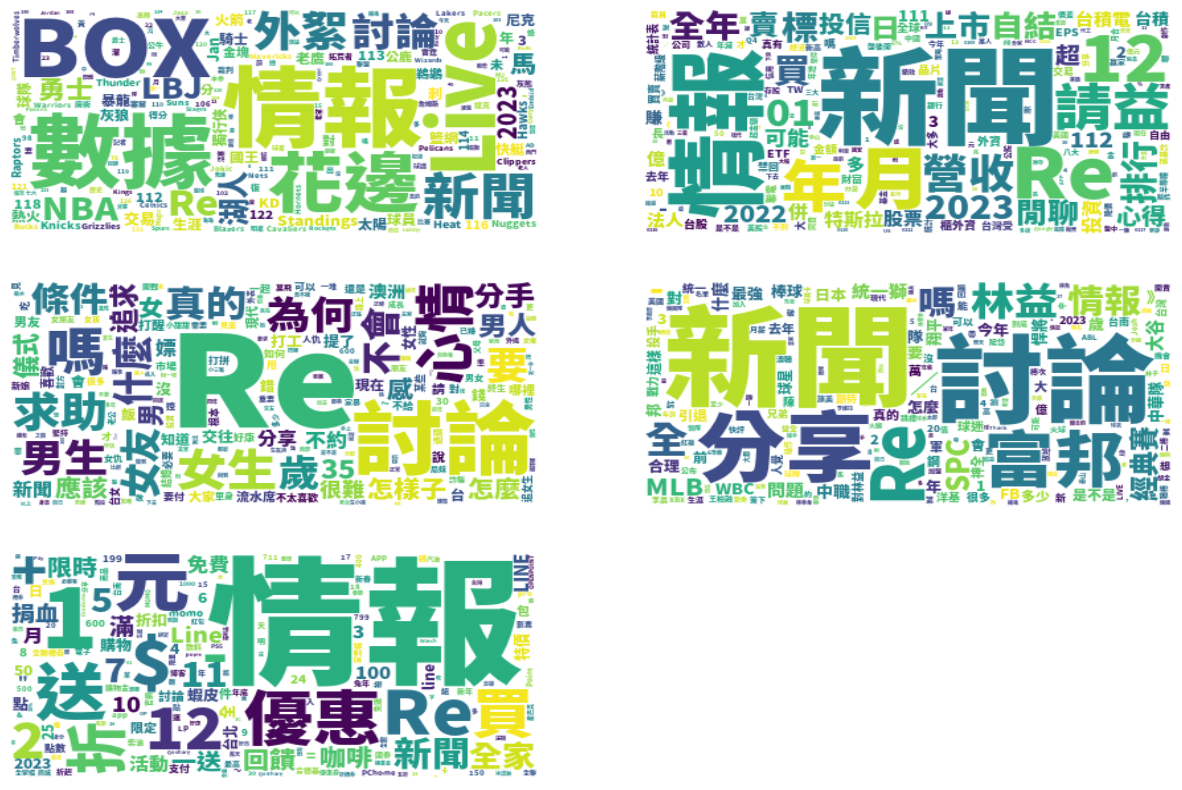

In [85]:
# Word Cloud (by board)
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
TC_FONT_PATH = 'NotoSansTC-Black.otf' # 繁體中文字型檔名


plt.figure(figsize=(15,10))
k=1
for board_name in df['board'].unique():
    textlist =[]
    filter = df['board']==board_name
    for text in df[filter]['text']:
        for word in text:
            textlist.append(word)
    each_dictionary = Counter(textlist)
    wordcloud = WordCloud(background_color="white",contour_width=3, contour_color='black',font_path=TC_FONT_PATH).generate_from_frequencies(each_dictionary)
    
    plt.subplot(3,2,k)
    plt.imshow(wordcloud, interpolation="bilinear",aspect="auto")
    plt.axis("off")
    k+=1

## Modeling

1. Train test split
2. Fit models : Logisti Regression, Random Forest, Gradiaent Boosting
3. Plot the results
4. Choose the best one

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [24]:
# Train Valid Split
y=df_train['board']
x_train,x_test,y_train,y_test = train_test_split(X_vector,y,test_size=0.2,random_state=1)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1852, 2258), (1852,), (464, 2258), (464,))

In [ ]:
#Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(x_train,y_train)
model_rf_score = model_rf.score(x_test,y_test)
print(model_rf_score)

In [ ]:
#SVM
model_svc =SVC()
model_svc.fit(x_test,y_test)
model_svc_score = model_svc.score(x_test,y_test)
print(model_svc_score)

In [ ]:
# Decision Tree
model_dt = RandomForestClassifier()
model_dt.fit(x_train,y_train)
model_dt_score = model_dt.score(x_test,y_test)
print(model_dt_score)

In [ ]:
#KNN
model_knn=KNeighborsClassifier(n_neighbors=4)
model_knn.fit(x_train,y_train)
model_knn_score = model_knn.score(x_test,y_test)
print(model_knn_score)

In [ ]:
#GradientBoostingClassifier
model_gbc = GradientBoostingClassifier()
model_gbc.fit(x_train,y_train)
model_gbc_score = model_gbc.score(x_test,y_test)
print(model_gbc_score)

In [90]:
df_score = pd.DataFrame(dict(model = ["DecisionTreeClassifier","RandomForest","GradientBoosting","SVC","KNN"],
                            accuracy = [model_dt_score,model_rf_score,model_gbc_score,model_svc_score,model_knn_score]))
df_score

,model,accuracy
0,DecisionTreeClassifier,0.855603
1,RandomForest,0.859914
2,GradientBoosting,0.864224
3,SVC,0.767241
4,KNN,0.709052


## Prediction

### Test Data

In [91]:
model = GradientBoostingClassifier()
model.fit(x_train,y_train)

GradientBoostingClassifier()

In [107]:
# 預測函式
def predict(textA,classifier): #回傳各版機率
    vector = vectorize(textA)
    prob = (classifier.predict_proba(vector.reshape(1, -1)))*100
    return prob

def best_class(problist):
    return np.argmax(problist)
    

In [109]:
#各版機率
df_test['prob_list'] = df_test['text'].apply(predict,args=(model,))
#最大值
df_test['model_prediction'] = df_test['prob_list'].apply(best_class)
#最大值mapping版名
df_test['board_prediction'] = df_test['model_prediction'].map({0:'NBA',1:'Stock',2:'Boy-Girl',3:'Baseball',4:'Lifeismoney'})

In [103]:
correct_count = df_test[df_test['board']==df_test['model_prediction']].count()[0]
correct_rate = correct_count/len(df_test)
print('Test Data Accuracy:',correct_rate)

Test Data Accuracy: 0.8911917098445595


### Postmeasurement

1. Input titles
2. jieba (apply cut_text)
3. vectorization (apply predict)
4. prediction (apply best_class , mapping)


In [128]:
post_df = pd.read_csv('0126.txt')
print(post_df)

                        title
0        Re: [情報] 全家APP刮刮樂又來了
1    [情報] 7-11 限時優惠 1/26~1/31
2  [新聞] 停權2年後 Meta宣布將恢復川普臉書帳號


In [129]:
post_df['text'] = post_df['title'].apply(cut_text)
post_df.head()

,title,text
0,Re: [情報] 全家APP刮刮樂又來了,Re 情報 全家 APP 刮 刮樂
1,[情報] 7-11 限時優惠 1/26~1/31,情報 7 - 11 限時 優惠 1 26 1 31
2,[新聞] 停權2年後 Meta宣布將恢復川普臉書帳號,新聞 停權 2 年 Meta 宣布 將恢 復 川 普臉 書 帳號


In [130]:
#各版機率
post_df['prob_list'] = post_df['text'].apply(predict,args=(model,))
#最大值
post_df['model_prediction'] = post_df['prob_list'].apply(best_class)
#最大值mapping版名
post_df['board_prediction'] = post_df['model_prediction'].map({0:'NBA',1:'Stock',2:'Boy-Girl',3:'Baseball',4:'Lifeismoney'})

post_df.head()

,title,text,prob_list,model_prediction,board_prediction
0,Re: [情報] 全家APP刮刮樂又來了,Re 情報 全家 APP 刮 刮樂,"[[5.1362141466907065, 5.871350813302591, 3.928...",4,Lifeismoney
1,[情報] 7-11 限時優惠 1/26~1/31,情報 7 - 11 限時 優惠 1 26 1 31,"[[1.2234550286112753, 2.9641094809875574, 0.48...",4,Lifeismoney
2,[新聞] 停權2年後 Meta宣布將恢復川普臉書帳號,新聞 停權 2 年 Meta 宣布 將恢 復 川 普臉 書 帳號,"[[16.74312323185091, 58.44501741733724, 4.1813...",1,Stock
